Dependecies and collecting images using openCV

In [7]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [8]:
import matplotlib.pyplot as plt
import json
import numpy as np


In [9]:
import os
import time
import uuid
import cv2


In [10]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 50

In [ ]:
import cv2
cap = cv2.VideoCapture(0)
# Check if the camera opened successfully
if not cap.isOpened():
    print("Error opening video stream or file")
    exit() 

for imgnum in range(number_images):
  print('Collecting image {}'.format(imgnum))
  ret, frame = cap.read()
  # Check if a frame was successfully read
  if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break
  imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
  cv2.imwrite(imgname, frame)
  cv2.imshow('frame', frame)
  time.sleep(0.5)

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

In [5]:
!labelme

Review dataset and build image loading function

In [11]:
gpu = tf.config.list_physical_devices('GPU')
len(gpu)

0

In [ ]:
# Load images into TF data pipeline
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=True)
images.as_numpy_iterator().next()

In [12]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)
images.as_numpy_iterator().next()

In [13]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [ ]:
# View images
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

fig, ax =plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()


Partition Unaugmented Data

In [13]:
# move the matching labels
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)



SETUP ALBUMENTATIONS TRANSFORM PIPELINE

In [14]:
import albumentations as alb
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params= alb.BboxParams(format='albumentations',
                                                     label_fields=['class_labels']))

In [15]:
img = cv2.imread(os.path.join('data','train','images','1a7b2367-6b92-11ef-9285-a511a15c1722.jpg'))
img.shape

(480, 640, 3)

In [16]:
#Load images
with open(os.path.join('data','train','labels','1a7b2367-6b92-11ef-9285-a511a15c1722.json'),'r') as f:
    label = json.load(f)

In [17]:
label['shapes'][0]['points']

[[228.02139037433156, 104.43850267379679],
 [390.0534759358288, 311.3903743315508]]

In [18]:
#Extract coordinates and rescale to match image resolution
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[228.02139037433156, 104.43850267379679, 390.0534759358288, 311.3903743315508]

In [19]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.3562834224598931,
 0.21758021390374332,
 0.6094585561497325,
 0.6487299465240641]

APPLY AUGMENTATIONS AND VIEW RESULTS

In [20]:
augmented = augmentor(image=img, bboxes=[coords],class_labels=['face'])
augmented['bboxes']

[(0.33782531194295906,
  0.36579916815210933,
  0.6978966131907307,
  0.8256922162804518)]

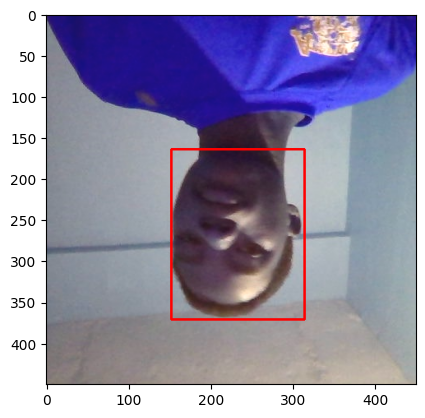

In [21]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
              (255,0,0),2)

plt.imshow(augmented['image'])

BUILD AND RUN AUGMENTATION PIPELINE

In [22]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img = cv2.imread(os.path.join('data',partition,'images',image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data',partition,'labels',f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition, 'images', f'{image.split(".")[0]}.{x}.jpg'),augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0

                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1

                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data',partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.32286096256684493, 0.9974376114081996, 0.051303475935828936, 0.7166889483065954, 'face'].


LOAD AUGMENTED IMAGES TO TENSORFLOW DATASET

In [23]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [24]:
train_images.as_numpy_iterator().next()

array([[[4.9558824e-01, 4.9166667e-01, 5.6225491e-01],
        [5.0980395e-01, 5.0196081e-01, 5.8431375e-01],
        [5.0275737e-01, 4.9491420e-01, 5.7726717e-01],
        ...,
        [7.3284316e-01, 7.7990198e-01, 7.7205884e-01],
        [7.2334558e-01, 7.7855390e-01, 7.7371323e-01],
        [7.3958331e-01, 8.0814952e-01, 8.0373776e-01]],

       [[4.9577206e-01, 4.9087009e-01, 5.6194854e-01],
        [5.0729167e-01, 5.0196081e-01, 5.7444853e-01],
        [5.2499998e-01, 5.1666665e-01, 5.9901959e-01],
        ...,
        [7.2990197e-01, 7.6911765e-01, 7.6519608e-01],
        [7.2647059e-01, 7.8382355e-01, 7.7169120e-01],
        [7.3774511e-01, 8.0000001e-01, 7.8725493e-01]],

       [[5.0557595e-01, 4.9381128e-01, 5.7616419e-01],
        [5.0294119e-01, 4.9117646e-01, 5.7352942e-01],
        [5.1317400e-01, 5.0140929e-01, 5.8376223e-01],
        ...,
        [7.3774511e-01, 7.7696079e-01, 7.7303922e-01],
        [7.4944854e-01, 7.9564953e-01, 7.8137255e-01],
        [7.3596811e-01

PREPARE LABELS

In [25]:
# BUILD LABEL LOADING FUNCTION
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)

    return [label['class']],label['bbox']

In [26]:
# LOAD LABELS TO  TENSORFLOW DATASET
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))



COMBINE LABEL AND IMAGE SAMPLES

In [27]:
#check partition lengths 
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4200, 4200, 840, 840, 900, 900)

In [28]:
# Create final dataset(images/labels)
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [52]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0]], dtype=uint8),
 array([[0.788  , 0.436  , 1.     , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.3262 , 0.456  , 0.6577 , 0.9253 ],
        [0.1259 , 0.1779 , 0.4954 , 0.7314 ],
        [0.06287, 0.2766 , 0.4385 , 0.803  ],
        [0.35   , 0.2053 , 0.679  , 0.6357 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

VIEW IMAGES AND ANNOTATIONS

In [29]:
data_samples = train.as_numpy_iterator()

In [30]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


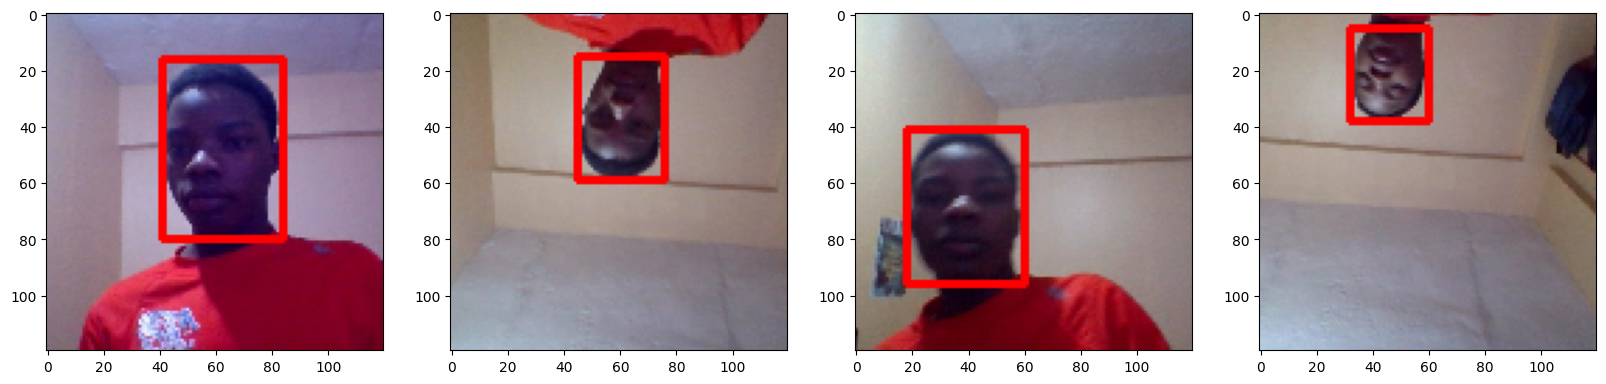

In [31]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = np.copy(res[0][idx])
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0),2
                  )
    ax[idx].imshow(sample_image)

BUILD A DEEP LEARNING USING FUNCTIONAL API

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D,Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [4]:
vgg = VGG16(include_top=False)
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 62s 1us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

BUILD INSTANCE OF NETWORK

In [6]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    
    vgg =VGG16(include_top=False)(input_layer)

    # classification model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1,activation='sigmoid')(class1)

    # regression bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs = [class2, regress2])
    return facetracker


TEST AOUT NEURAL NETWORK

In [32]:
facetracker = build_model()
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
X,y = train.as_numpy_iterator().next()

In [38]:
X.shape

(8, 120, 120, 3)

In [39]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(array([[0.4451556 ],
        [0.3582614 ],
        [0.3766186 ],
        [0.338259  ],
        [0.30721104],
        [0.35957995],
        [0.42400685],
        [0.2950655 ]], dtype=float32),
 array([[0.39455935, 0.5894283 , 0.22668329, 0.5755283 ],
        [0.43798196, 0.6232264 , 0.19014147, 0.60403895],
        [0.34594387, 0.5646428 , 0.23173167, 0.5619441 ],
        [0.39907143, 0.6046588 , 0.1787322 , 0.6486896 ],
        [0.363866  , 0.6207116 , 0.26232603, 0.5221503 ],
        [0.44078866, 0.5909532 , 0.20995517, 0.60215414],
        [0.42176527, 0.6099851 , 0.23900612, 0.5447538 ],
        [0.46588796, 0.6004586 , 0.2535972 , 0.5839142 ]], dtype=float32))

DIFINE LOSSES AND OPTIMIZERS

In [42]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [43]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [50]:
# create localization loss and classification loss
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [51]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [53]:
# test out loss metrics
localization_loss(y[1],coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.237263>

In [54]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8822944>